In [1]:
import pandas as pd
import os
import numpy as np
import glob
import urllib.request, json 
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
import h5py
from bokeh.plotting import figure
from bokeh.io import output_file, show, output_notebook
from bokeh.models import CustomJS
from bokeh.models.widgets import CheckboxGroup
from bokeh.layouts import row
from bokeh.palettes import Viridis4
from bokeh.models.annotations import Title, Legend

In [2]:
def live_url_req():
    with urllib.request.urlopen("https://api.covid19india.org/v3/timeseries.json") as url:
        df_district_wise_case = json.loads(url.read().decode())['WB']
        #print(df_district_wise_case)
        return df_district_wise_case

In [3]:
j = live_url_req()

time_series_wb = pd.DataFrame()
for k,v in j.items():
    #print("key = ", k,"value = ",v)
    for k1,v1 in v.items():
        if k1 == 'total':
            if(not(('tested' in v1)  & ('deceased' in v1) & ('recovered' in v1))):
                temp_1 = pd.DataFrame({"Date":[k],  "Deceased": np.nan , "Recovered": np.nan, "Tested" : np.nan, "Confirmed":[v1['confirmed']]})
            elif(not(('tested' in v1)  & ('recovered' in v1))):
                temp_1 = pd.DataFrame({"DateDate":[k], "Deceased": [v1['deceased']] , "Recovered": np.nan, "Tested" : np.nan, "Confirmed":[v1['confirmed']]})
            elif(not(('tested' in v1))):
                temp_1 = pd.DataFrame({"Date":[k], "Deceased": [v1['deceased']] , "Recovered":[v1['recovered']], "Tested" : np.nan, "Confirmed":[v1['confirmed']]})
            else:
                temp_1 = pd.DataFrame({"Date":[k], "Deceased": [v1['deceased']] , "Recovered":[v1['recovered']], "Tested" : [v1['tested']],  "Confirmed":[v1['confirmed']]})
            
            time_series_wb = time_series_wb.append(temp_1, ignore_index = True)
        

time_series_wb[-7:]


,Date,Deceased,Recovered,Tested,Confirmed
231,2020-11-03,7013.0,342133.0,4688295.0,385589
232,2020-11-04,7068.0,346262.0,4733508.0,389576
233,2020-11-05,7122.0,350449.0,4778975.0,393524
234,2020-11-06,7177.0,354732.0,4824327.0,397466
235,2020-11-07,7235.0,359071.0,4869554.0,401394
236,2020-11-08,7294.0,363454.0,4914741.0,405314
237,2020-11-09,7350.0,367850.0,4959087.0,409221


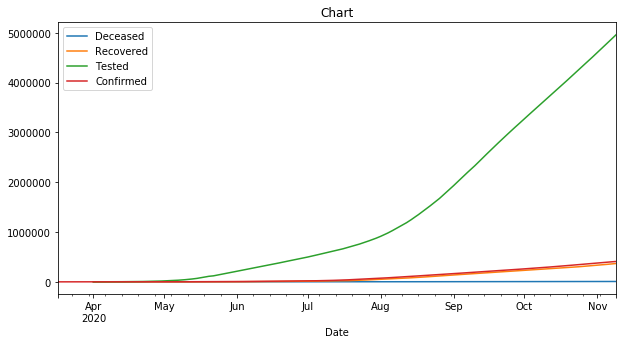

In [4]:
time_series_wb['Date'] = time_series_wb['Date'].apply(pd.to_datetime)
time_series_wb.set_index("Date", inplace = True )
time_series_wb.plot(figsize=(10,5),title="Chart")

In [5]:
df_new = time_series_wb
df_new.drop(df_new.columns[[0,1,2]],axis =1, inplace = True)
df_new

,Confirmed
Date,
2020-03-17,1
2020-03-18,1
2020-03-19,1
2020-03-20,2
2020-03-21,4
...,...
2020-11-05,393524
2020-11-06,397466
2020-11-07,401394


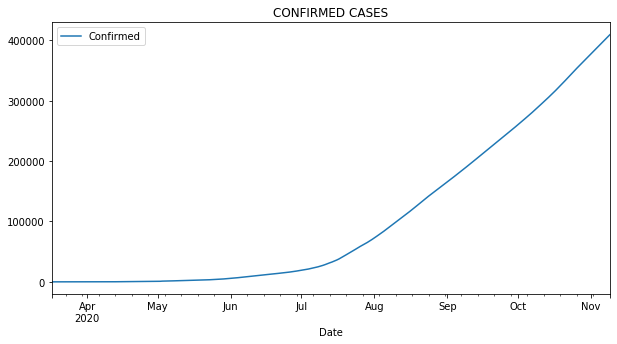

In [6]:
time_series_wb.plot(figsize=(10,5),title="CONFIRMED CASES")

In [7]:
total_data = time_series_wb.shape[0]

In [8]:
x = 12
train_size = total_data - x
test_size = x

In [9]:
train = df_new[:train_size]
test = df_new[train_size:]
test

,Confirmed
Date,
2020-10-29,365692
2020-10-30,369671
2020-10-31,373664
2020-11-01,377651
2020-11-02,381608
2020-11-03,385589
2020-11-04,389576
2020-11-05,393524
2020-11-06,397466


In [10]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)
scaled_test,scaled_train

(array([[1.01102842],
        [1.02202918],
        [1.03306866],
        [1.04409154],
        [1.05503149],
        [1.06603779],
        [1.07706067],
        [1.08797574],
        [1.09887421],
        [1.10973398],
        [1.12057163],
        [1.13137334]]),
 array([[0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [2.76470686e-06],
        [8.29412057e-06],
        [1.65882411e-05],
        [1.65882411e-05],
        [2.21176549e-05],
        [2.21176549e-05],
        [2.48823617e-05],
        [3.87058960e-05],
        [4.70000166e-05],
        [5.52941372e-05],
        [5.80588440e-05],
        [9.95294469e-05],
        [9.95294469e-05],
        [1.43764757e-04],
        [1.43764757e-04],
        [1.43764757e-04],
        [2.18411842e-04],
        [2.18411842e-04],
        [2.48823617e-04],
        [2.70941272e-04],
        [2.82000100e-04],
        [3.17941289e-04],
        [3.45588357e-04],
        [3.67706012e-04],
        [4.17470736e-04],
      

In [11]:
scaled_train.shape,  scaled_test.shape

((226, 1), (12, 1))

In [12]:
## how to decide num of inputs , 
n_input = 5  ## number of steps
n_features = 1 ## number of features you want to predict (for univariate time series n_features=1)
generator = TimeseriesGenerator(scaled_train,scaled_train,length = n_input,batch_size=1)

In [13]:
len(generator)

221

In [14]:
x,y = generator[50]
(x.shape,y.shape)

((1, 5, 1), (1, 1))

In [15]:
model = Sequential()
model.add(LSTM(300,activation="relu",input_shape=(n_input,n_features)))
#model.add(Dropout(0.2))
model.add(Dense(75, activation='relu'))
model.add(Dense(units=1))
#model.add(Activation('softmax'))
#model.add(Dense(1))
model.compile(optimizer="adam",loss="mse")


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 300)               362400    
_________________________________________________________________
dense (Dense)                (None, 75)                22575     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 76        
Total params: 385,051
Trainable params: 385,051
Non-trainable params: 0
_________________________________________________________________


In [17]:
validation_set = scaled_test
validation_set=validation_set.reshape(12,1)
validation_set

array([[1.01102842],
       [1.02202918],
       [1.03306866],
       [1.04409154],
       [1.05503149],
       [1.06603779],
       [1.07706067],
       [1.08797574],
       [1.09887421],
       [1.10973398],
       [1.12057163],
       [1.13137334]])

In [18]:
n_input = 5
n_features = 1
validation_gen = TimeseriesGenerator(validation_set,validation_set,length=5,batch_size=1)

In [19]:
validation_gen[0],validation_gen[1]

((array([[[1.01102842],
          [1.02202918],
          [1.03306866],
          [1.04409154],
          [1.05503149]]]),
  array([[1.06603779]])),
 (array([[[1.02202918],
          [1.03306866],
          [1.04409154],
          [1.05503149],
          [1.06603779]]]),
  array([[1.07706067]])))

In [20]:
validation_gen[0][0].shape,validation_gen[0][1].shape

((1, 5, 1), (1, 1))

In [21]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=20,restore_best_weights=True)

In [22]:
model.fit_generator(generator,validation_data=validation_gen,epochs=100,callbacks=[early_stop],steps_per_epoch=10)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
10/10 [==============================] - 2s 204ms/step - loss: 0.0386 - val_loss: 0.8142
Epoch 2/100
10/10 [==============================] - 0s 19ms/step - loss: 0.0799 - val_loss: 0.4483
Epoch 3/100
10/10 [==============================] - 0s 16ms/step - loss: 0.0170 - val_loss: 0.0315
Epoch 4/100
10/10 [==============================] - 0s 22ms/step - loss: 0.0050 - val_loss: 3.8450e-04
Epoch 5/100
10/10 [==============================] - 0s 16ms/step - loss: 0.0022 - val_loss: 0.0312
Epoch 6/100
10/10 [==============================] - 0s 15ms/step - loss: 0.0024 - val_loss: 0.0045
Epoch 7/100
10/10 [==============================] - 0s 15ms/step - loss: 9.1158e-04 - val_loss: 1.7998e-04
Epoch 8/100
10/10 [==============================] - 0s 15ms/step - loss: 4.6109e-04 - val_loss: 0.0019
Epoch 9/100
10/10 [==============================] - 0s 16ms/step - loss: 1.7124e-04 - val_loss: 1.2712e-04

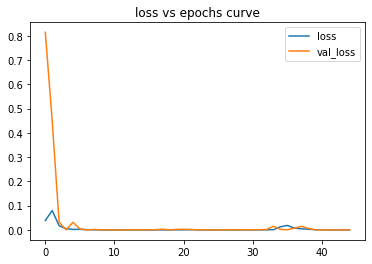

In [23]:
pd.DataFrame(model.history.history).plot(title="loss vs epochs curve")

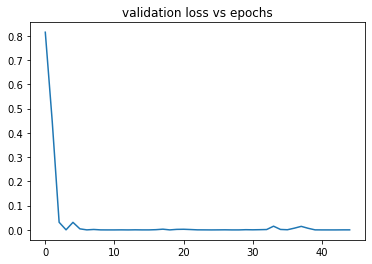

In [24]:
myloss = model.history.history["val_loss"]
plt.title("validation loss vs epochs")
plt.plot(range(len(myloss)),myloss)

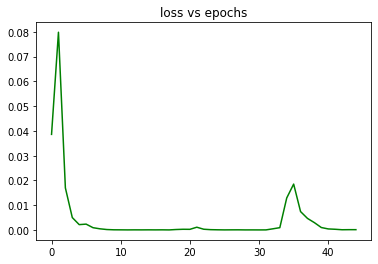

In [25]:
myloss = model.history.history["loss"]
plt.title("loss vs epochs")
plt.plot(range(len(myloss)),myloss,c='g')

In [26]:
## holding predictions
test_prediction = []

##last n points from training set
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape(1,n_input,n_features)


In [27]:
first_eval_batch

array([[0.95540804],
       [0.96681799],
       [0.97821135],
       [0.98915129],
       [1.        ]])

In [28]:
current_batch

array([[[0.95540804],
        [0.96681799],
        [0.97821135],
        [0.98915129],
        [1.        ]]])

In [29]:
current_batch.shape
window = 10

In [30]:
## how far in future we can predict
for i in range(len(test)+window):
    current_pred = model.predict(current_batch)[0]
    test_prediction.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [31]:
test_prediction

[array([1.0061489], dtype=float32),
 array([1.0166488], dtype=float32),
 array([1.0269684], dtype=float32),
 array([1.0371244], dtype=float32),
 array([1.0471623], dtype=float32),
 array([1.0569974], dtype=float32),
 array([1.0676472], dtype=float32),
 array([1.0783522], dtype=float32),
 array([1.0891709], dtype=float32),
 array([1.1001529], dtype=float32),
 array([1.1113583], dtype=float32),
 array([1.1228912], dtype=float32),
 array([1.1346449], dtype=float32),
 array([1.1466427], dtype=float32),
 array([1.1589261], dtype=float32),
 array([1.1715261], dtype=float32),
 array([1.1844674], dtype=float32),
 array([1.1977559], dtype=float32),
 array([1.2113763], dtype=float32),
 array([1.2253237], dtype=float32),
 array([1.2396729], dtype=float32),
 array([1.2544427], dtype=float32)]

In [32]:
true_prediction = scaler.inverse_transform(test_prediction)
true_prediction[:,0]

array([363927.08185744, 367724.8931818 , 371457.50972962, 375130.96805429,
       378761.69620466, 382319.08023143, 386171.13429976, 390043.15211248,
       393956.30472469, 397928.48620534, 401981.51438308, 406152.98836184,
       410404.3173182 , 414743.95242691, 419186.89883494, 423744.32416606,
       428425.24013209, 433231.71640849, 438158.23386073, 443203.02464104,
       448393.16700315, 453735.43051052])

In [33]:
time_series_array = test.index
for k in range(0,window):
    time_series_array = time_series_array.append(time_series_array[-1:] + pd.DateOffset(1))
time_series_array

DatetimeIndex(['2020-10-29', '2020-10-30', '2020-10-31', '2020-11-01',
               '2020-11-02', '2020-11-03', '2020-11-04', '2020-11-05',
               '2020-11-06', '2020-11-07', '2020-11-08', '2020-11-09',
               '2020-11-10', '2020-11-11', '2020-11-12', '2020-11-13',
               '2020-11-14', '2020-11-15', '2020-11-16', '2020-11-17',
               '2020-11-18', '2020-11-19'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [34]:
df_forecast = pd.DataFrame(columns=["Confirmed","Confirmed_predicted"],index=time_series_array)
df_forecast

,Confirmed,Confirmed_predicted
Date,,
2020-10-29,NaN,NaN
2020-10-30,NaN,NaN
2020-10-31,NaN,NaN
2020-11-01,NaN,NaN
2020-11-02,NaN,NaN
2020-11-03,NaN,NaN
2020-11-04,NaN,NaN
2020-11-05,NaN,NaN
2020-11-06,NaN,NaN


In [35]:
df_forecast.loc[:,"Confirmed_predicted"] = true_prediction[:,0]
df_forecast.loc[:,"Confirmed"] = test["Confirmed"]

In [36]:
df_forecast

,Confirmed,Confirmed_predicted
Date,,
2020-10-29,365692.0,363927.081857
2020-10-30,369671.0,367724.893182
2020-10-31,373664.0,371457.509730
2020-11-01,377651.0,375130.968054
2020-11-02,381608.0,378761.696205
2020-11-03,385589.0,382319.080231
2020-11-04,389576.0,386171.134300
2020-11-05,393524.0,390043.152112
2020-11-06,397466.0,393956.304725


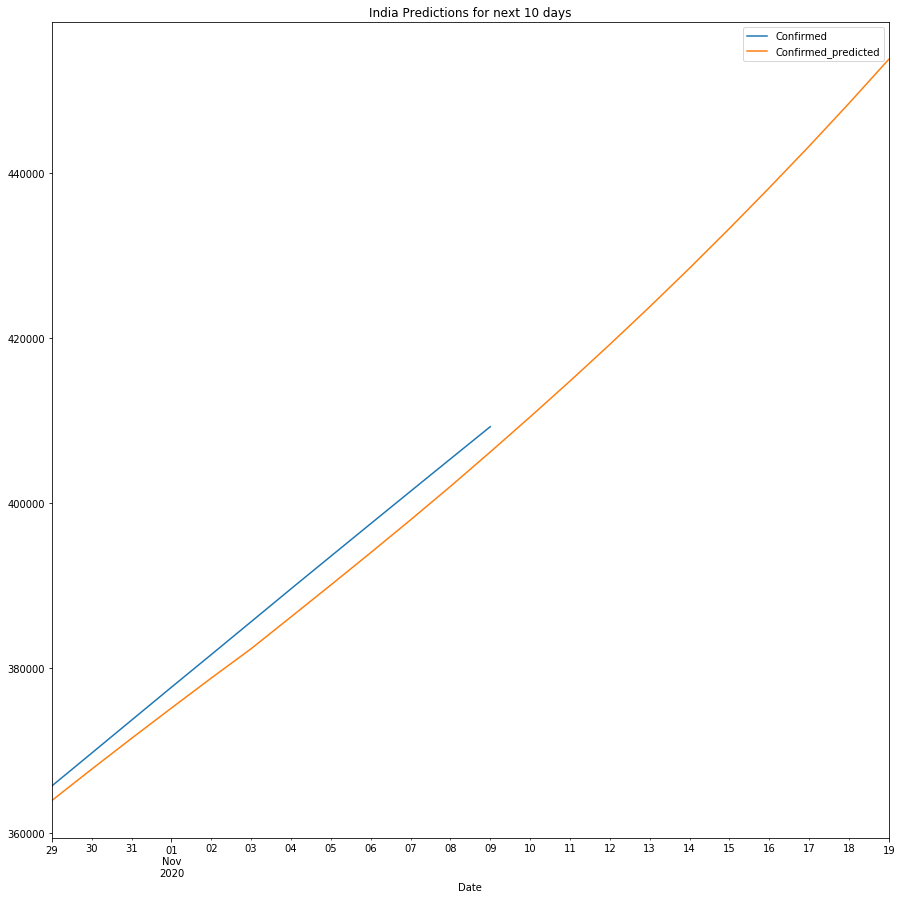

In [37]:
s = "India Predictions for next "+str(window)+" days"
df_forecast.plot(title=s,figsize=(15,15))

In [38]:
MAPE = tf.keras.metrics.mean_absolute_percentage_error(df_forecast["Confirmed"][:12], df_forecast["Confirmed_predicted"][:12]).numpy()
print("MAPE is " + str(MAPE) + " %")

MAPE is 0.7447995088210801 %


In [39]:
Accuracy = 100 -MAPE
Accuracy

99.25520049117893

In [40]:
df_forecast["Error"] =  abs(df_forecast["Confirmed"][:11] -  df_forecast["Confirmed_predicted"][:11])

In [41]:
df_forecast

,Confirmed,Confirmed_predicted,Error
Date,,,
2020-10-29,365692.0,363927.081857,1764.918143
2020-10-30,369671.0,367724.893182,1946.106818
2020-10-31,373664.0,371457.509730,2206.490270
2020-11-01,377651.0,375130.968054,2520.031946
2020-11-02,381608.0,378761.696205,2846.303795
2020-11-03,385589.0,382319.080231,3269.919769
2020-11-04,389576.0,386171.134300,3404.865700
2020-11-05,393524.0,390043.152112,3480.847888
2020-11-06,397466.0,393956.304725,3509.695275


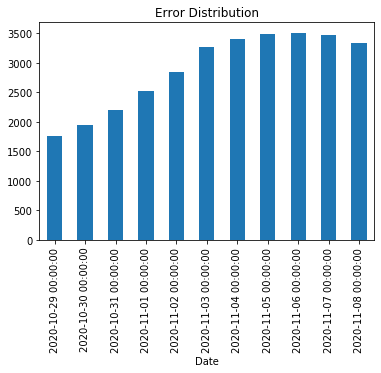

In [42]:
(df_forecast["Error"][:11]).plot.bar(title = 'Error Distribution')

In [43]:
sum_errs = np.sum((np.array(df_forecast["Confirmed"][:12]) - np.array(df_forecast["Confirmed_predicted"][:12]))**2)
sum_errs

105470563.74478927

In [44]:
stdev = np.sqrt(1/(12-2) * sum_errs)
stdev

3247.6231884993877

In [45]:
# calculate prediction interval
interval = 1.96 * stdev
interval

6365.3414494588

In [46]:
df_forecast["Confirm_min"] = df_forecast["Confirmed_predicted"] - interval
df_forecast["Confirm_max"] = df_forecast["Confirmed_predicted"] + interval
df_forecast

,Confirmed,Confirmed_predicted,Error,Confirm_min,Confirm_max
Date,,,,,
2020-10-29,365692.0,363927.081857,1764.918143,357561.740408,370292.423307
2020-10-30,369671.0,367724.893182,1946.106818,361359.551732,374090.234631
2020-10-31,373664.0,371457.509730,2206.490270,365092.168280,377822.851179
2020-11-01,377651.0,375130.968054,2520.031946,368765.626605,381496.309504
2020-11-02,381608.0,378761.696205,2846.303795,372396.354755,385127.037654
2020-11-03,385589.0,382319.080231,3269.919769,375953.738782,388684.421681
2020-11-04,389576.0,386171.134300,3404.865700,379805.792850,392536.475749
2020-11-05,393524.0,390043.152112,3480.847888,383677.810663,396408.493562
2020-11-06,397466.0,393956.304725,3509.695275,387590.963275,400321.646174


In [47]:
df_forecast["Model Accuracy"] = round((100-MAPE),2)
df_forecast

,Confirmed,Confirmed_predicted,Error,Confirm_min,Confirm_max,Model Accuracy
Date,,,,,,
2020-10-29,365692.0,363927.081857,1764.918143,357561.740408,370292.423307,99.26
2020-10-30,369671.0,367724.893182,1946.106818,361359.551732,374090.234631,99.26
2020-10-31,373664.0,371457.509730,2206.490270,365092.168280,377822.851179,99.26
2020-11-01,377651.0,375130.968054,2520.031946,368765.626605,381496.309504,99.26
2020-11-02,381608.0,378761.696205,2846.303795,372396.354755,385127.037654,99.26
2020-11-03,385589.0,382319.080231,3269.919769,375953.738782,388684.421681,99.26
2020-11-04,389576.0,386171.134300,3404.865700,379805.792850,392536.475749,99.26
2020-11-05,393524.0,390043.152112,3480.847888,383677.810663,396408.493562,99.26
2020-11-06,397466.0,393956.304725,3509.695275,387590.963275,400321.646174,99.26


In [48]:
from datetime import datetime
df_forecast["District"] = "West Bengal"
df_forecast["Execution date"] = str(datetime.now()).split()[0]
df_forecast

,Confirmed,Confirmed_predicted,Error,Confirm_min,Confirm_max,Model Accuracy,District,Execution date
Date,,,,,,,,
2020-10-29,365692.0,363927.081857,1764.918143,357561.740408,370292.423307,99.26,West Bengal,2020-11-09
2020-10-30,369671.0,367724.893182,1946.106818,361359.551732,374090.234631,99.26,West Bengal,2020-11-09
2020-10-31,373664.0,371457.509730,2206.490270,365092.168280,377822.851179,99.26,West Bengal,2020-11-09
2020-11-01,377651.0,375130.968054,2520.031946,368765.626605,381496.309504,99.26,West Bengal,2020-11-09
2020-11-02,381608.0,378761.696205,2846.303795,372396.354755,385127.037654,99.26,West Bengal,2020-11-09
2020-11-03,385589.0,382319.080231,3269.919769,375953.738782,388684.421681,99.26,West Bengal,2020-11-09
2020-11-04,389576.0,386171.134300,3404.865700,379805.792850,392536.475749,99.26,West Bengal,2020-11-09
2020-11-05,393524.0,390043.152112,3480.847888,383677.810663,396408.493562,99.26,West Bengal,2020-11-09
2020-11-06,397466.0,393956.304725,3509.695275,387590.963275,400321.646174,99.26,West Bengal,2020-11-09


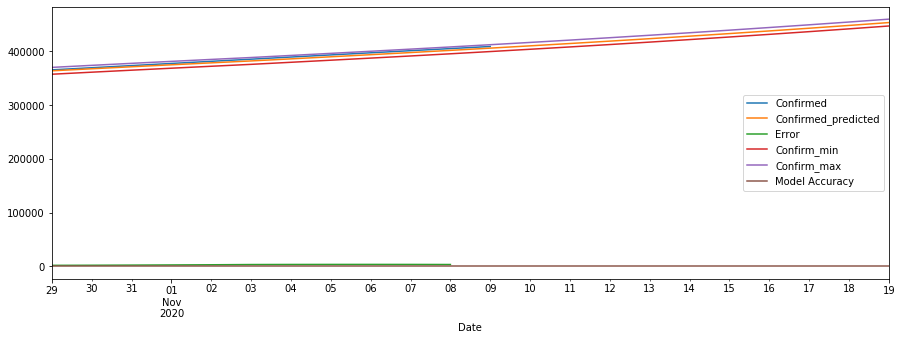

In [49]:
#df_forecast.figure(figsize=(8,8))
df_forecast.iloc[:,:11].plot(figsize=(15,5))

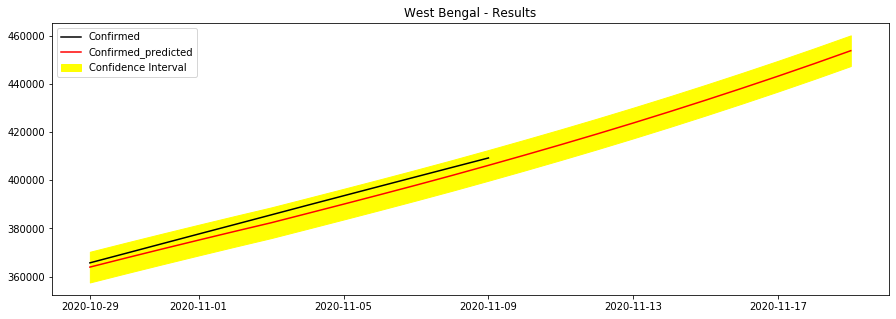

In [50]:
ig= plt.figure(figsize=(15,5))
plt.title("{} - Results".format("West Bengal"))
plt.plot(df_forecast.index,df_forecast["Confirmed"],label="Confirmed",color="black")
plt.plot(df_forecast.index,df_forecast["Confirmed_predicted"],label="Confirmed_predicted",color="red")
#ax.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)
plt.fill_between(df_forecast.index,df_forecast["Confirm_min"],df_forecast["Confirm_max"],color="yellow",alpha=0.99,label="Confidence Interval")
plt.legend()
plt.show()

In [51]:
from keras.models import load_model
name = "covid_WB_.h5"
model.save(name)

In [52]:
from keras.models import load_model
model1 = load_model(name)

In [53]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 300)               362400    
_________________________________________________________________
dense (Dense)                (None, 75)                22575     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 76        
Total params: 385,051
Trainable params: 385,051
Non-trainable params: 0
_________________________________________________________________


In [54]:
df_forecast.to_excel(r'C:\Users\User\Desktop\cov_pred2.xlsx', sheet_name = 'cov_pred2')

In [55]:
df = pd.read_excel(r"C:\Users\User\Desktop\cov_pred2.xlsx")
df

,Date,Confirmed,Confirmed_predicted,Error,Confirm_min,Confirm_max,Model Accuracy,District,Execution date
0,2020-10-29,365692.0,363927.081857,1764.918143,357561.740408,370292.423307,99.26,West Bengal,2020-11-09
1,2020-10-30,369671.0,367724.893182,1946.106818,361359.551732,374090.234631,99.26,West Bengal,2020-11-09
2,2020-10-31,373664.0,371457.509730,2206.490270,365092.168280,377822.851179,99.26,West Bengal,2020-11-09
3,2020-11-01,377651.0,375130.968054,2520.031946,368765.626605,381496.309504,99.26,West Bengal,2020-11-09
4,2020-11-02,381608.0,378761.696205,2846.303795,372396.354755,385127.037654,99.26,West Bengal,2020-11-09
5,2020-11-03,385589.0,382319.080231,3269.919769,375953.738782,388684.421681,99.26,West Bengal,2020-11-09
6,2020-11-04,389576.0,386171.134300,3404.865700,379805.792850,392536.475749,99.26,West Bengal,2020-11-09
7,2020-11-05,393524.0,390043.152112,3480.847888,383677.810663,396408.493562,99.26,West Bengal,2020-11-09
8,2020-11-06,397466.0,393956.304725,3509.695275,387590.963275,400321.646174,99.26,West Bengal,2020-11-09
9,2020-11-07,401394.0,397928.486205,3465.513795,391563.144756,404293.827655,99.26,West Bengal,2020-11-09


In [56]:


df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

p = figure(x_axis_type='datetime', plot_width=800)
aline = p.line(df['Date'], df['Confirm_min'], line_width=2, color=Viridis4[0])
bline = p.line(df['Date'], df['Confirm_max'], line_width=2, color=Viridis4[1])
cline = p.line(df['Date'], df['Confirmed_predicted'], line_width=2, color=Viridis4[2])
#dline = p.line(df['dDate'], df['close'], line_width=2, color=Viridis4[3])

p.yaxis.axis_label = 'Cases'
p.xaxis.axis_label = 'Time Span'

legend = Legend(items=[
    ("Confirm_min",   [aline]),
    ("Confirm_max", [bline]),
    ("Confirmed_predicted", [cline]),
], location=(0, 450))

t = Title()
t.text = 'Covid-19 Time Series Prediction'
p.title = t

p.add_layout(legend, 'left')

checkboxes = CheckboxGroup(labels=list(['Confirm_min', 'Confirm_max', 'Confirmed_predicted', 
                          ]), active=[0, 1, 2])
callback = CustomJS(code="""aline.visible = false; // aline and etc.. are 
                            bline.visible = false; // passed in from args
                            cline.visible = false; 
                            // cb_obj is injected in thanks to the callback
                            if (cb_obj.active.includes(0)){aline.visible = true;} 
                                // 0 index box is aline
                            if (cb_obj.active.includes(1)){bline.visible = true;} 
                                // 1 index box is bline
                            if (cb_obj.active.includes(2)){cline.visible = true;} 
                                // 2 index box is cline etc...
                            """,
                    args={'aline': aline, 'bline': bline, 'cline': cline})
checkboxes.js_on_click(callback)
output_file('Tesla_Stock_Widget.html')
show(row(p, checkboxes))

In [57]:
df

,Date,Confirmed,Confirmed_predicted,Error,Confirm_min,Confirm_max,Model Accuracy,District,Execution date
0,2020-10-29,365692.0,363927.081857,1764.918143,357561.740408,370292.423307,99.26,West Bengal,2020-11-09
1,2020-10-30,369671.0,367724.893182,1946.106818,361359.551732,374090.234631,99.26,West Bengal,2020-11-09
2,2020-10-31,373664.0,371457.509730,2206.490270,365092.168280,377822.851179,99.26,West Bengal,2020-11-09
3,2020-11-01,377651.0,375130.968054,2520.031946,368765.626605,381496.309504,99.26,West Bengal,2020-11-09
4,2020-11-02,381608.0,378761.696205,2846.303795,372396.354755,385127.037654,99.26,West Bengal,2020-11-09
5,2020-11-03,385589.0,382319.080231,3269.919769,375953.738782,388684.421681,99.26,West Bengal,2020-11-09
6,2020-11-04,389576.0,386171.134300,3404.865700,379805.792850,392536.475749,99.26,West Bengal,2020-11-09
7,2020-11-05,393524.0,390043.152112,3480.847888,383677.810663,396408.493562,99.26,West Bengal,2020-11-09
8,2020-11-06,397466.0,393956.304725,3509.695275,387590.963275,400321.646174,99.26,West Bengal,2020-11-09
9,2020-11-07,401394.0,397928.486205,3465.513795,391563.144756,404293.827655,99.26,West Bengal,2020-11-09


In [58]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.plotly as py
import plotly
import pandas as pd
import datetime


df['Date'] = df['Date'].apply(pd.to_datetime)

df['Date'] = df['Date'].astype('str') 
df['high'] = df['Confirm_max'].astype('double')
df['low'] = df['Confirm_min'].astype('double') 


df.fillna(0)
df.head()


high = go.Scatter(
    x=df.Date,
    y=df['Confirm_max'],
    name = "MAXIMUM CASES",
    line = dict(color = '#17BECF'),
    opacity = 0.8)

medium = go.Scatter(
    x=df.Date,
    y=df['Confirmed_predicted'],
    name = "Predicted CASES",
    line = dict(color = '#ff7f0e'),
    opacity = 0.8)


low = go.Scatter(
    x=df.Date,
    y=df['Confirm_min'],
    name = "MINIMUM CASES",
    line = dict(color = '#7F7F7F'),
    opacity = 0.8)

data = [high,medium,low]

layout = dict(
    title='Time Series with Rangeslider',
      xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=30,
                     label='30d',
                     step='day',
                     stepmode='backward'),
                dict(count=7,
                     label='7d',
                     step='day',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

fig = dict(data=data, layout=layout)

iplot(fig, filename = "Time Series with Rangeslider")
plotly.offline.plot(fig, filename='Plotly_Stock.html')

'Plotly_Stock.html'